# A Sparser Way to Connect Graphs

### Austin Du's COGS 118B Final Project 

Inspired by Linderman, Mishne, Jaffe, Kluger, and Steinerberger<br>
https://arxiv.org/abs/1711.04712 [1]

In [1]:
from OT_functions import *
import scipy.stats as stats
import time

import warnings
warnings.filterwarnings('ignore')

In [34]:
def draw_graph(G, color):
    plt.cla()
    nx.drawing.nx_pylab.draw_networkx(G, pos = nx.get_node_attributes(G,'pos'), 
                                      with_labels = False, node_size = 20, linewidths = 0.5, 
                                      node_color = color, edge_color = 'grey')

    return G

## Generate Some Data

In [3]:
def uniform_X(n = 500, d = 2):
    return np.random.uniform(0, 1, d*n).reshape(n, d)

def skewed_X(a, b, n = 500, d = 2):
    return stats.beta.rvs(a, b, size = d*n).reshape(n, d)
    

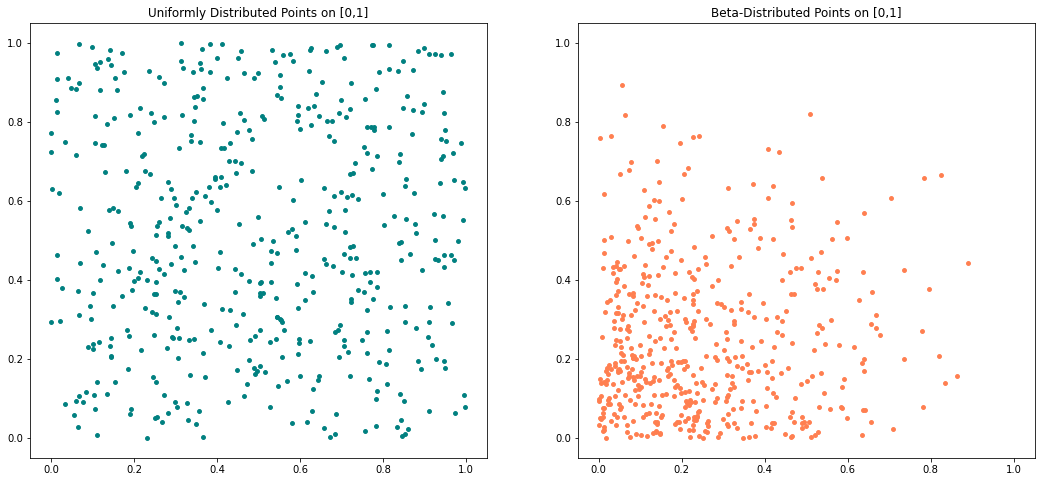

In [160]:
fig, axs = plt.subplots(1, 2, figsize = (18,8))
axs[0].set_title('Uniformly Distributed Points on [0,1]')
axs[1].set_title('Beta-Distributed Points on [0,1]')

X1 = uniform_X()
nbrs = get_k_neighbors(X1, 3)
plt.sca(axs[0])
plt.scatter(X1[:,0], X1[:,1], color = 'teal', s = 15)
plt.xlim(-.05,1.05)
plt.ylim(-.05,1.05)

X2 = skewed_X(1, 3)
nbrs = get_k_neighbors(X2, 3)
plt.sca(axs[1])
plt.scatter(X2[:,0], X2[:,1], color = 'coral', s = 15)
plt.xlim(-.05,1.05)
plt.ylim(-.05,1.05)

plt.show()

## Connecting k Nearest Neighbors

* Use sklearn's k-Nearest-Neighbors Algorithm to connect each point to its k nearest points.
* This is the traditional method.

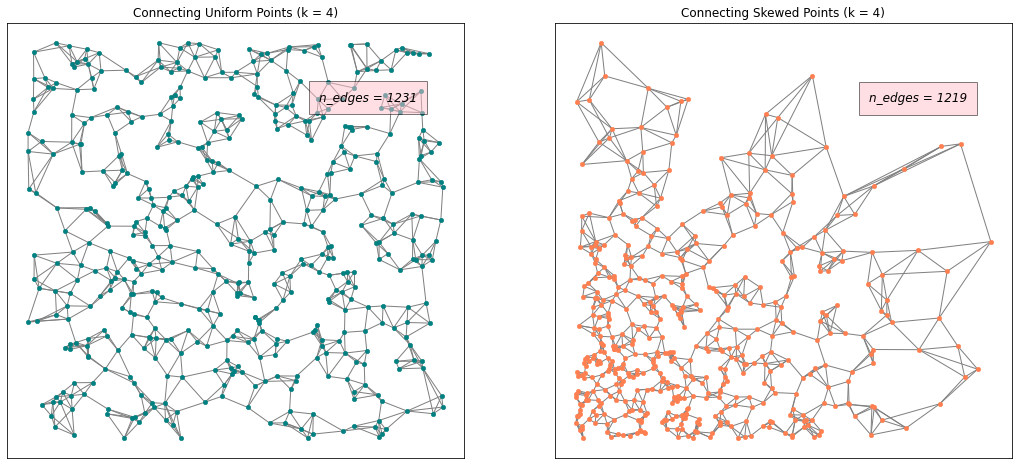

In [184]:
fig, axs = plt.subplots(1, 2, figsize = (18,8))

nearest_nbrs1 = get_k_neighbors(X1, 4)
nearest_nbrs2 = get_k_neighbors(X2, 4)

plt.sca(axs[0])
G5 = create_graph(X1, nearest_nbrs1)
draw_graph(G5, 'teal')
plt.text(0.7, .85, 'n_edges = {}'.format(G5.number_of_edges()), style='italic', size = 12,
                 bbox={'facecolor': 'pink', 'alpha': 0.5, 'pad': 10})
plt.title('Connecting Uniform Points (k = 4)')

plt.sca(axs[1])
G6 = create_graph(X2, nearest_nbrs2)
draw_graph(G6, 'coral')
plt.text(.63, .76, 'n_edges = {}'.format(G6.number_of_edges()), style='italic', size = 12,
                 bbox={'facecolor': 'pink', 'alpha': 0.5, 'pad': 10})
plt.title('Connecting Skewed Points (k = 4)')

plt.show()

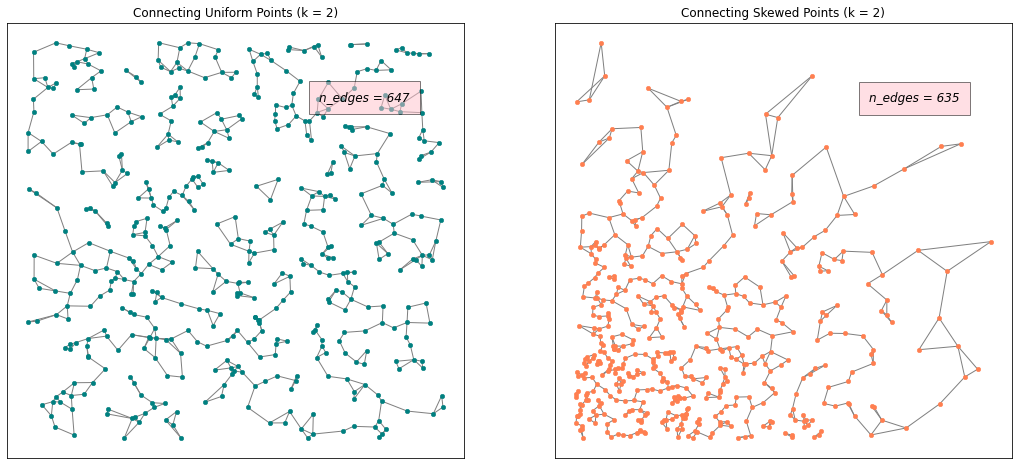

In [183]:
fig, axs = plt.subplots(1, 2, figsize = (18,8))

nearest_nbrs1 = get_k_neighbors(X1, 2)
nearest_nbrs2 = get_k_neighbors(X2, 2)

plt.sca(axs[0])
G1 = create_graph(X1, nearest_nbrs1)
draw_graph(G1, 'teal')
plt.text(0.7, .85, 'n_edges = {}'.format(G1.number_of_edges()), style='italic', size = 12,
                 bbox={'facecolor': 'pink', 'alpha': 0.5, 'pad': 10})
plt.title('Connecting Uniform Points (k = 2)')

plt.sca(axs[1])
G2 = create_graph(X2, nearest_nbrs2)
draw_graph(G2, 'coral')
plt.text(.63, .76, 'n_edges = {}'.format(G2.number_of_edges()), style='italic', size = 12,
                 bbox={'facecolor': 'pink', 'alpha': 0.5, 'pad': 10})
plt.title('Connecting Skewed Points (k = 2)')

plt.show()

## The Solution

* Devised in [1], consider many neighbors for each point, but only connect each point with a certain uniform likelihood.
* Look at the K nearest points around you. Expect to connect to only k of them.
* We call this the k-of-K Random Near Neighbors approach.
* Pretty significant flaw.

## The Better Solution

* Recommended in [1] but not proven, partition the points into K/k groups, and connect to k nearest neighbors within each group.
* This both maintains connectivity, and is requires less operating time.

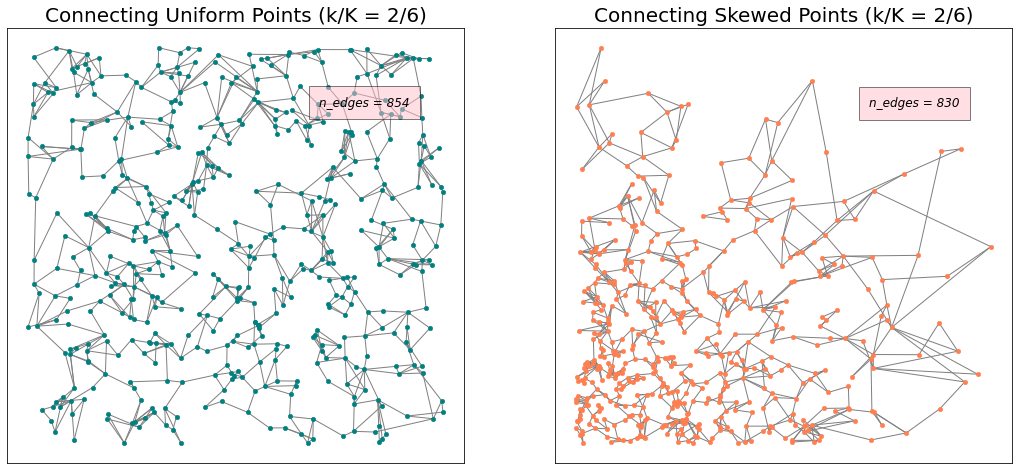

In [182]:
fig, axs = plt.subplots(1, 2, figsize = (18,8))

partitioned_nbrs1 = get_k_partitioned_neighbors(X1, 2, 3)
partitioned_nbrs2 = get_k_partitioned_neighbors(X2, 2, 3)

plt.sca(axs[0])
G3 = create_graph(X1, partitioned_nbrs1)
draw_graph(G3, 'teal')
plt.text(.7, .85, 'n_edges = {}'.format(G3.number_of_edges()), style='italic', size = 12,
                 bbox={'facecolor': 'pink', 'alpha': 0.5, 'pad': 10})
plt.title('Connecting Uniform Points (k/K = 2/6)', size = 20)

plt.sca(axs[1])
G4 = create_graph(X2, partitioned_nbrs2)
draw_graph(G4, 'coral')
plt.text(.63, .76, 'n_edges = {}'.format(G4.number_of_edges()), style='italic', size = 12,
                 bbox={'facecolor': 'pink', 'alpha': 0.5, 'pad': 10})
plt.title('Connecting Skewed Points (k/K = 2/6)', size = 20)

plt.show()

## Why do we care?

* Edge-based algorithms are more efficient with fewer edges.
* For example, optimal transport problems.
    - Given a source and sink distribution on nodes, what are the most efficient paths to take?
   

In [121]:
def make_uniform_pmf(X, source_center, sink_center, r_source = 0.5, r_sink = 0.5):
    
    assert len(source_center) == X.shape[1], 'dimension of source_center must match that of points in X'
    assert len(sink_center) == X.shape[1], 'dimension of sink_center must match that of points in X'
    
    # create binary arrays that identify whether a node is source or sink
    is_source = np.apply_along_axis(lambda x: 1 if np.linalg.norm(x - source_center) <= r_source else 0, 1, X)
    is_sink = np.apply_along_axis(lambda x: 1 if np.linalg.norm(x - sink_center) <= r_sink else 0, 1, X)
    
    # normalize arrays to sum to 1
    source_pmf = is_source / is_source.sum()
    sink_pmf = is_sink / is_sink.sum()
    
    return source_pmf - sink_pmf

def get_M(G, alpha = 1):
    if G == None:
        return -1
    
    sum_weights = 0
    for (u, v) in G.edges:
        edge = G[u][v]
        sum_weights += (edge['weight']**alpha) * edge['euc_dist']
    return sum_weights

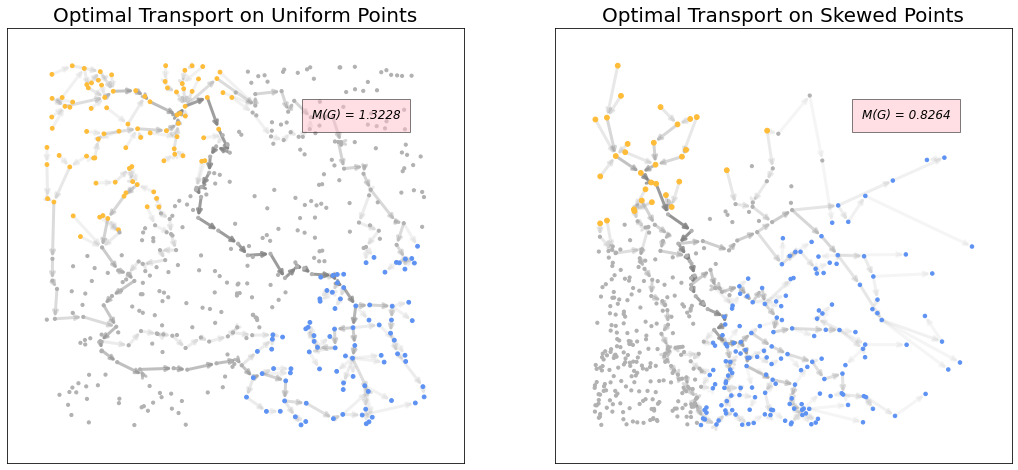

In [185]:
fig, axs = plt.subplots(1, 2, figsize = (18,8))

X1_pmf = make_uniform_pmf(X1, (0,1), (1,0))
X2_pmf = make_uniform_pmf(X2, (0,1), (1,0), r_sink = .75)

plt.sca(axs[0])
dg1 = create_digraph(X1, partitioned_nbrs1, X1_pmf)
draw_digraph(dg1)
plt.text(.7, .85, 'M(G) = {}'.format(np.round(get_M(dg1), 4)), style='italic', size = 12,
                 bbox={'facecolor': 'pink', 'alpha': 0.5, 'pad': 10})
plt.title('Optimal Transport on Uniform Points', size = 20)

plt.sca(axs[1])
dg2 = create_digraph(X2, partitioned_nbrs2, X2_pmf)
draw_digraph(dg2)
plt.text(.63, .76, 'M(G) = {}'.format(np.round(get_M(dg2), 4)), style='italic', size = 12,
                 bbox={'facecolor': 'pink', 'alpha': 0.5, 'pad': 10})
plt.title('Optimal Transport on Skewed Points', size = 20)

plt.show()

## Simulate 300 times

* On uniform distribution, calculate optimal transport based on k-Nearest graph and Partitioned-Near graph
* Track transport length (M(G))
* Track computation time

In [131]:
n = 300
weights_nearest = np.empty(n)
weights_partition = np.empty(n)
time_nearest = np.empty(n)
time_partition = np.empty(n)

for i in range(n):
    X = uniform_X()
    neighbors_partition = get_k_partitioned_neighbors(X, 2, 3)
    neighbors_nearest = get_k_neighbors(X, 6)
    pmf = make_uniform_pmf(X, [0,0], (1,1))
    
    start_time = time.time()
    G_nearest = create_digraph(X, neighbors_nearest, pmf)
    time_nearest[i] = time.time() - start_time
    
    start_time = time.time()
    G_partition = create_digraph(X, neighbors_partition, pmf)
    time_partition[i] = time.time() - start_time
    
    weights_nearest[i] = get_M(G_nearest)
    weights_partition[i] = get_M(G_partition)

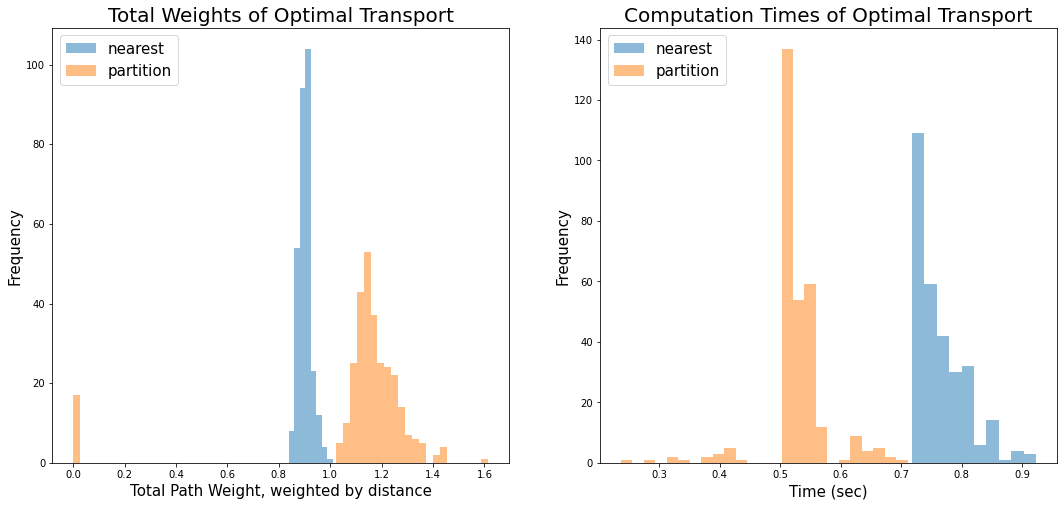

In [146]:
fig, axs = plt.subplots(1, 2, figsize = (18,8))

plt.sca(axs[0])
plt.hist(weights_nearest, bins=8, alpha=0.5, label="nearest")
plt.hist(weights_partition, bins=60, alpha=0.5, label="partition")
plt.legend(loc='upper left', prop={'size': 15})
plt.title('Total Weights of Optimal Transport', size = 20)
plt.xlabel('Total Path Weight, weighted by distance', size = 15)
plt.ylabel('Frequency', size = 15)

plt.sca(axs[1])
plt.hist(time_nearest, bins=10, alpha=0.5, label="nearest")
plt.hist(time_partition, bins=25, alpha=0.5, label="partition")
plt.legend(loc='upper left', prop={'size': 15})
plt.title('Computation Times of Optimal Transport', size = 20)
plt.xlabel('Time (sec)', size = 15)
plt.ylabel('Frequency', size = 15)

plt.show()

## Conclusion

* When connecting random points, the new partition algorithm can generate sparser graphs while maintaining connectivity
* Since the the connection conditions are loosened, edge distances will be longer on average
* The new graphs can potentially speed up calculations, as seen in the case of optimal transport